# StyleGAN

## Assignment_1:

End to End implementation (Forward pass)

 * Build a neural architecture
 * Import pre-trained weight
 * Input samples of data into the model, deploy the model, get outputs




## Paper Reference:

Karras, T., Laine, S., & Aila, T. (2018). A Style-Based generator architecture for generative adversarial networks. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1812.04948


## Code Reference:

https://www.digitalocean.com/community/tutorials/implementation-stylegan-from-scratch

https://github.com/kevinMEH/simple-stylegan/tree/main

## Dataset:

Flickr-Faces-HQ Dataset (FFHQ)

https://www.kaggle.com/datasets/arnaud58/flickrfaceshq-dataset-ffhq


*  We will load dataset from kaggle.

In [ ]:


import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/flickrfaceshq-dataset-ffhq/27147.png
/kaggle/input/flickrfaceshq-dataset-ffhq/52235.png
/kaggle/input/flickrfaceshq-dataset-ffhq/32352.png
/kaggle/input/flickrfaceshq-dataset-ffhq/41695.png
/kaggle/input/flickrfaceshq-dataset-ffhq/21130.png
/kaggle/input/flickrfaceshq-dataset-ffhq/36145.png
/kaggle/input/flickrfaceshq-dataset-ffhq/22897.png
/kaggle/input/flickrfaceshq-dataset-ffhq/18966.png
/kaggle/input/flickrfaceshq-dataset-ffhq/22069.png
/kaggle/input/flickrfaceshq-dataset-ffhq/47434.png
/kaggle/input/flickrfaceshq-dataset-ffhq/52691.png
/kaggle/input/flickrfaceshq-dataset-ffhq/32860.png
/kaggle/input/flickrfaceshq-dataset-ffhq/37825.png
/kaggle/input/flickrfaceshq-dataset-ffhq/27326.png
/kaggle/input/flickrfaceshq-dataset-ffhq/44033.png
/kaggle/input/flickrfaceshq-dataset-ffhq/43294.png
/kaggle/input/flickrfaceshq-dataset-ffhq/50028.png
/kaggle/input/flickrfaceshq-dataset-ffhq/34514.png
/kaggle/input/flickrfaceshq-dataset-ffhq/01301.png
/kaggle/input/flickrfaceshq-dat

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from math import log2


In [ ]:
### Initial Configuration


batch_size = 16

device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda": raise Exception("Please enable CUDA.")

z_dimensions = 384
w_dimensions = 384

###################

batches_per_epoch = 800
epochs_per_double = 48
current_epoch = 0
current_doubles = 0
maximum_doubles = 3
alpha_recovery_epochs = epochs_per_double // 2

load_models_from_epoch = None
#load_model_directory = Path("./models/stylegan/xxx")
#save_model_base_directory = Path("./models/stylegan")

###################

#mapping_network = MappingNetwork(z_dimensions, w_dimensions).to(device)
#generator = Generator(w_dimensions, image_resolution=16 * 2**maximum_doubles, starting_channels=448).to(device)
#discriminator = Discriminator(image_resolution=16 * 2**maximum_doubles, max_channels=448).to(device)

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path
from os import listdir
from PIL import Image
from torchvision import transforms
DATASET_PATH = "kaggle/input/flickrfaceshq-dataset-ffhq"
class FFHQDataset(Dataset):
    def __init__(self, path=DATASET_PATH, file_prefix="", file_postfix=".png", image_size=128):
        self.path = Path(path)
        self.file_prefix = file_prefix
        self.file_postfix = file_postfix
        self.length = len(listdir(path))

        # Define the transformation pipeline
        self.transform = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),  # Resize to the desired size
                transforms.ToTensor(),  # Convert PIL image to tensor
                transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
                transforms.Normalize(
                    [0.5 for _ in range(3)],  # Normalize for RGB images (mean = 0.5 for each channel)
                    [0.5 for _ in range(3)],  # Normalize for RGB images (std = 0.5 for each channel)
                ),
            ]
        )

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Construct the file name and path
        padded_index = str(index).rjust(5, "0")  # Pad index with leading zeros (e.g., 00001)
        file_name = self.file_prefix + padded_index + self.file_postfix
        file_path = Path.joinpath(self.path, file_name)

        # Load the image
        image = Image.open(file_path)

        # Apply transformations
        image = self.transform(image)

        return image


### Stylegan Implementation


* Noise Mapping Network
* Adaptive Instance Normalization (AdaIN)
* Progressive growing


first build a class with the name CLinear (weighted scaled Linear) which will be inherited from nn.Module.

In the init part we send input features and output channels. Create a linear layer, then we define a scale that will be equal to the square root of 2 divided by in_features, we copy the bias of the current column layer into a variable because we don’t want the bias of the linear layer to be scaled, then we remove it, Finally, we initialize linear layer.
In the forward part, we send x and all that we are going to do is multiplicate x with scale and add the bias after reshaping it.

In [ ]:
class CLinear(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.linear = nn.Linear(input, output)
        self.scale = (2 / input)**0.5
        self.bias = self.linear.bias
        self.linear.bias = None
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)
    def forward(self, x):
        return self.linear(x * self.scale) + self.bias * self.scale

In [ ]:
class CConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
        self.scale = (2 / (input_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)
    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(-1, 1, 1) * self.scale


We will create the MappingNetwork class.

In the init part we send z_dim and w_din, and we define the network mapping that first normalizes z_dim, followed by eight of WSLInear and ReLU as activation functions.
In the forward part, we return the network mapping.

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dimensions, w_dimensions, rms_norm_epsilon = 1e-6):
        super().__init__()
        self.rms_norm_epsilon = rms_norm_epsilon
        self.mapping = nn.Sequential(
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, z_dimensions),
            nn.LeakyReLU(0.2),
            CLinear(z_dimensions, w_dimensions),
        )

    def forward(self, z):
        # RMS Norm
        z = z * (torch.mean(z**2, dim=1, keepdim=True) + self.rms_norm_epsilon).rsqrt()
        return self.mapping(z)

Adaptive Instance Normalization (AdaIN)

Now let’s create AdaIN class

In the init part w_e_ send channels, w_dim, and we initialize instance_norm which will be the instance normalization part, and we initialize style_scale and style_bias which will be the adaptive parts with WSLinear that maps the Noise Mapping Network W into channels.
In the forward pass, we send x, apply instance normalization for it, and return style_sclate * x + style_bias.

In [ ]:
class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, w_dimensions, channels):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale_network = CLinear(w_dimensions, channels)
        self.style_shift_network = CLinear(w_dimensions, channels)

    def forward(self, x_and_w): # Accept x_and_w tuple for nn.Sequential compatibility
        x, w = x_and_w
        x = self.instance_norm(x)
        style_scale = self.style_scale_network(w).unsqueeze(2).unsqueeze(3)
        style_shift = self.style_shift_network(w).unsqueeze(2).unsqueeze(3)
        return (style_scale * x + style_shift, w) # Return both for next layer


Inject Noise

Now let’s create the class InjectNoise to inject the noise into the generator

In the init part we sent channels and we initialize weight from a random normal distribution and we use nn.Parameter so that these weights can be optimized
In the forward part, we send an image x and we return it with random noise added

In [ ]:
class InjectNoise(nn.Module):
    def __init__(self, channels, image_dimensions):
        super().__init__()
        self.image_dimensions = image_dimensions
        self.register_parameter("scale", nn.Parameter(torch.zeros([channels, 1, 1])))

    def forward(self, x_and_w): # Accept x_and_w tuple for nn.Sequential compatibility
        x, w = x_and_w
        noise = torch.randn([x.shape[0], 1, self.image_dimensions, self.image_dimensions], device=x.device)
        return (x + self.scale * noise, w) # Returns both for next layer

class LeakyReLUFirst(nn.Module):
    def __init__(self, negative_slope=0.01):
        super().__init__()
        self.leaky_relu = nn.LeakyReLU(negative_slope)
    def forward(self, x_and_w):
        x, w = x_and_w
        return (self.leaky_relu(x), w)


StyleGAN is built upon the official implementation of ProGAN (Karras et al.), they use the same discriminator architecture, adaptive minibatch size, hyperparameters, etc. So there are a lot of classes that stay the same from ProGAN implementation.

In this section, we will create the classes that do not change from the ProGAN architecture.

In the code snippet below you can find the class WSConv2d (weighted scaled convolutional layer) to Equalized Learning Rate for the conv layers.

In [ ]:
class ConvNoiseNorm(nn.Module):
    def __init__(self, in_channels, out_channels, image_dimensions, w_dimensions):
        super().__init__()
        self.conv = CConv2d(in_channels, out_channels, 3, 1, 1)
        self.noise_relu_norm = nn.Sequential(
            InjectNoise(out_channels, image_dimensions),
            LeakyReLUFirst(0.2),
            AdaptiveInstanceNorm(w_dimensions, out_channels),
        )

    def forward(self, x_and_w): # Accept x_and_w tuple for nn.Sequential compatibility
        x, w = x_and_w
        x = self.conv(x)
        return self.noise_relu_norm((x, w)) # Return both for next layer



### Class Generator


Generator  generates high-resolution images progressively. It starts with a small feature map (e.g., 4x4) and upsamples it step-by-step to the target resolution. The generator uses adaptive instance normalization (AdaIN) to condition the output on a latent vector w and employs smooth transitions between resolutions using a blending factor alpha.

In the init part we send in_channels, out_channels, and w_dim, then we initialize conv1 by WSConv2d which maps in_channels to out_channels, conv2 by WSConv2d which maps out_channels to out_channels, leaky by Leaky ReLU with a slope of 0.2 as they use in the paper, inject_noise1, inject_noise2 by the InjectNoise, adain1, and adain2 by AdaIN
In the forward part, we send x, and we pass it to conv1 then to inject_noise1 with leaky, then we normalize it with adain1, and again we pass that into conv2 then to inject_noise2 with leaky and we normalize it with adain2. And finally, we return x

In [ ]:
class Generator(nn.Module):
    # We don't include the mapping network here as we are going to perform mixing regularization
    def __init__(self, w_dimensions, image_resolution, image_channels=3, starting_dimensions=4, starting_channels=384):
        super().__init__()
        self.starting_dimension_log2 = int(log2(starting_dimensions))

        self.doubles_required = int(log2(image_resolution)) - self.starting_dimension_log2
        self.register_parameter("starting_constant", nn.Parameter(torch.ones([starting_channels, starting_dimensions, starting_dimensions])))

        channels = [ min(64 * 2**i, starting_channels) for i in range(self.doubles_required) ]
        channels.reverse() # From starting_channels -> 64 channels
        self.initial = nn.Sequential(
            InjectNoise(starting_channels, starting_dimensions),
            LeakyReLUFirst(0.2),
            AdaptiveInstanceNorm(w_dimensions, starting_channels),
            ConvNoiseNorm(starting_channels, starting_channels, starting_dimensions, w_dimensions)
        )

        self.post_upsample_list = nn.ModuleList()
        self.rgb_converter_list = nn.ModuleList()
        last_channel = starting_channels
        current_dimension = starting_dimensions
        for channel in channels:
            current_dimension = current_dimension * 2
            self.post_upsample_list.append(nn.Sequential(
                ConvNoiseNorm(last_channel, channel, current_dimension, w_dimensions),
                ConvNoiseNorm(channel, channel, current_dimension, w_dimensions),
            ))
            self.rgb_converter_list.append(nn.Sequential(
                CConv2d(channel, image_channels, 1),
                nn.Tanh()
            ))
            last_channel = channel

    def forward(self, w, resolution, alpha): # Starts at 16
        resolution_log2 = int(log2(resolution))
        current_doubles_required = resolution_log2 - self.starting_dimension_log2

        x = self.starting_constant.repeat([w.shape[0], 1, 1, 1])
        x, w = self.initial((x, w))
        # Go through doubles but manually do last one for interpolation
        for doubling in self.post_upsample_list[:current_doubles_required - 1]:
            x = F.interpolate(x, scale_factor=2, mode="bilinear")
            x, w = doubling((x, w))

        upscaled_x = F.interpolate(x, scale_factor=2, mode="bilinear")
        upscaled_x_rgb = self.rgb_converter_list[current_doubles_required - 2](upscaled_x)

        x, w = self.post_upsample_list[current_doubles_required - 1]((upscaled_x, w))
        x_rgb = self.rgb_converter_list[current_doubles_required - 1](x)

        # After we double resolution, for the first few iterations we will
        # interpolate the upscaled resolution of the image processed through the
        # old generator with the new double resolution generated image. Low
        # alpha = new image less weight, high alpha = new image more weight.
        return torch.lerp(x_rgb, upscaled_x_rgb, 1 - alpha)


Class Discreminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_resolution, image_channels=3, max_channels=384):
        super().__init__()
        self.image_resolution_log2 = int(log2(image_resolution))
        channels = [ min(64 * 2**i, max_channels) for i in range(self.image_resolution_log2) ]

        # Always the first layer, converts from RGB to next layer channels
        self.rgb_converter_list = nn.ModuleList()
        self.pre_downsample_list = nn.ModuleList()
        last_channel = channels[0]
        # Stop at 2^2, or 4x4 because that is our final convolutions
        for channel in channels[:0 - 2]: # High resolution channels -> Low resolution channels
            self.rgb_converter_list.append(nn.Sequential(
                CConv2d(image_channels, last_channel, 3, 1, 1),
                nn.LeakyReLU(0.2),
            ))
            self.pre_downsample_list.append(
                nn.Sequential(
                    CConv2d(last_channel, channel, 3, 1, 1),
                    nn.LeakyReLU(0.2),
                    CConv2d(channel, channel, 3, 1, 1),
                    nn.LeakyReLU(0.2),
                )
            )
            last_channel = channel
        # In official implementations unncessary 0 padding is introduced in the
        # convolutional layer which maintains 4x4 size with 0s on the sides, but
        # adds unnecessary parameters into fully connected layers (they are
        # constant 0s. Why pass 0s into linear layers?). This is now removed.
        self.output = nn.Sequential(
            # Conv might not even be necessary, maybe remove and use 4x4 linear
            CConv2d(last_channel, last_channel, 3),
            nn.Flatten(),
            CLinear(last_channel * 2 * 2, last_channel),
            nn.LeakyReLU(0.2),
            CLinear(last_channel, 1)
        )

    def forward(self, x, resolution, alpha): # Resolution start at 16
        resolution_log2 = int(log2(resolution))
        start_index = self.image_resolution_log2 - resolution_log2

        half_x = F.interpolate(x, scale_factor=0.5, mode="bilinear")
        half_x = self.rgb_converter_list[start_index + 1](half_x)

        # Manually conv down once to interpolate before going through conv down
        # loop.
        x = self.rgb_converter_list[start_index](x)
        x = self.pre_downsample_list[start_index](x)
        x = F.interpolate(x, scale_factor=0.5, mode="bilinear")

        # After we double resolution, for the first few iterations we will
        # interpolate the half resolution of the image processed through the
        # previous discriminator pipeline with the full resolution image
        # processed through the new discriminator pipeline with the new front
        # blocks. Low alpha = new blocks results less weight, high alpha = new
        # block results greater weight.
        x = torch.lerp(x, half_x, 1 - alpha)

        # Proceed through conv down loop as normal
        for pre_downsample in self.pre_downsample_list[start_index + 1:]:
            x = pre_downsample(x)
            x = F.interpolate(x, scale_factor=0.5, mode="bilinear")
        return self.output(x)

## Importing pre-trained weigths

stylegan_NON_SAT - 64

In [ ]:
generator = Generator(
    w_dimensions=384,
    image_resolution=128,
    image_channels=3,
    starting_dimensions=4,
    starting_channels=448
)
discriminator = Discriminator(
    image_resolution=128,
    image_channels=3,
    max_channels=448
)

In [ ]:
#checkpoint = torch.load("/kaggle/input/stylegan/pytorch/default/1")
#enerator.load_state_dict(checkpoint["generator_state_dict"])

generator.load_state_dict(torch.load("/kaggle/input/stylegan/pytorch/default/1/generator_47.pth"))
discriminator.load_state_dict(torch.load("/kaggle/input/stylegan/pytorch/default/1/discriminator_47.pth"))

<ipython-input-17-969d6999737c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/kaggle/input/stylegan/pytorch/default/1/generator_47.

<All keys matched successfully>

In [ ]:
# Initialize the mapping network
mapping_network = MappingNetwork(z_dimensions=384, w_dimensions=384)

# Load pretrained weights
mapping_network.load_state_dict(torch.load("/kaggle/input/stylegan/pytorch/default/1/mapping_network_47.pth"))
mapping_network.eval()  # Set to evaluation mode

<ipython-input-19-52dbeec1e7f8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mapping_network.load_state_dict(torch.load("/kaggle/input/stylegan/pytorch/default/1/mapping

MappingNetwork(
  (mapping): Sequential(
    (0): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (5): LeakyReLU(negative_slope=0.2)
    (6): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (7): LeakyReLU(negative_slope=0.2)
    (8): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (9): LeakyReLU(negative_slope=0.2)
    (10): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (11): LeakyReLU(negative_slope=0.2)
    (12): CLinear(
      (linear): Linear(in_features=384, out_features=384, bias=False)
    )
    (13): LeakyReLU(negative_slope=0.2)
    (14): CLinear(
     

## Input sample and generated images

In [ ]:
z = torch.randn(16, 384)  # Random latent vector
w = mapping_network(z)     # Map z to w (if using a mapping network)
#images = generator(w, resolution=128, alpha=1.0)  # Generate image

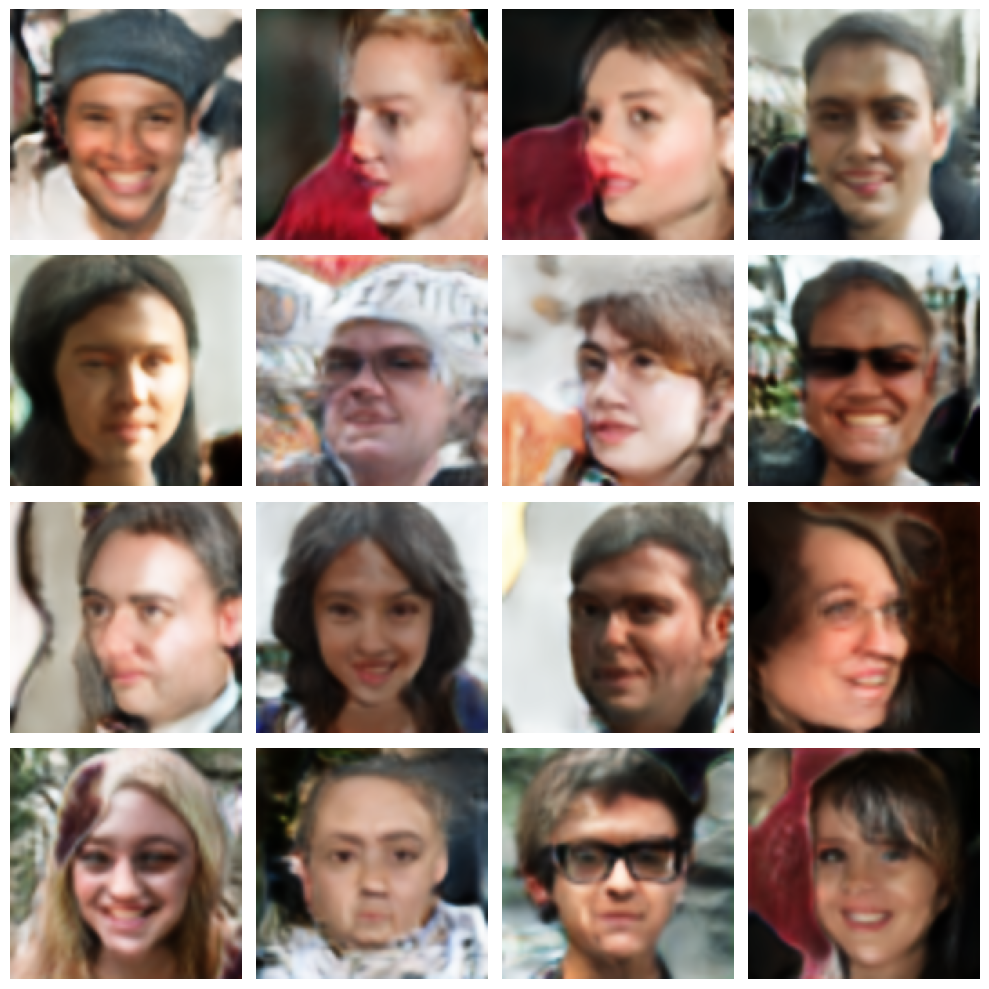

In [ ]:
import torch
import matplotlib.pyplot as plt

# Map z to w using the mapping network
with torch.no_grad():
    w = mapping_network(z)

    # Generate images using the generator
    images = generator(w, resolution=128, alpha=0.0001)

# Normalize images from [-1, 1] to [0, 1] for display
images = (images + 1) / 2

# Convert tensor to numpy and permute dimensions for matplotlib
images = images.cpu().numpy()
images = images.transpose(0, 2, 3, 1)  # Change from (N, C, H, W) to (N, H, W, C)

# Create a grid of subplots
num_images = images.shape[0]
nrows = 4  # Number of rows in the grid
ncols = 4  # Number of columns in the grid

# Create a figure and subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

# Display each image in the grid
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])  # Display the image
        ax.axis("off")  # Hide axes
    else:
        ax.axis("off")  # Hide axes for empty subplots

# Adjust layout and display
plt.tight_layout()
plt.show()